# Stock Market Analysis  

In [1]:
!pip install pandas numpy matplotlib statsmodels pandas-datareader datetime yfinance scikit-learn PyPortfolioOpt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install pandas-ta


Defaulting to user installation because normal site-packages is not writeable


## Data Collection & Fetching S&P 500 Data  


In [3]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings

warnings.filterwarnings('ignore')

snp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
snp500['Symbol'] = snp500['Symbol'].str.replace('.', '-')
symbols = snp500['Symbol'].unique().tolist()
endDate = '2025-03-19'
startDate = pd.to_datetime(endDate) - pd.DateOffset(365*8)
df = yf.download(tickers = symbols, start=startDate, end=endDate, auto_adjust=False).stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df

[*********************100%***********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-03-21 A        49.444359   52.660000   53.730000   52.480000   53.279999   
           AAPL     32.481499   34.959999   35.700001   34.932499   35.527500   
           ABBV     46.380825   65.349998   66.000000   65.040001   65.959999   
           ABT      38.809986   44.799999   45.380001   44.599998   45.150002   
           ACGL     29.671204   31.203333   31.736668   31.173332   31.726667   
...                       ...         ...         ...         ...         ...   
2025-03-18 XYL     120.919998  120.919998  122.949997  120.639999  122.669998   
           YUM     157.300003  157.300003  157.940002  156.160004  156.710007   
           ZBH     112.638672  112.879997  113.940002  111.349998  111.660004   
           ZBRA    282.579987  282.579987  285.540009  281.920013  282.720001   
           ZTS     164.429993  164.429993  165.419998  163.240005  165.119995   

Price                   volume  
date       ticker               
2017-03-21 A         1492700.0  
           AAPL    158119600.0  
           ABBV      5187400.0  
           ABT       5567100.0  
           ACGL       980100.0  
...                        ...  
2025-03-18 XYL       1346600.0  
           YUM       1332200.0  
           ZBH       1619300.0  
           ZBRA       323500.0  
           ZTS       1879300.0  

[990469 rows x 6 columns]

## Calculating Technical Indicators for Each Stock
- Garman Klass Volatility
- RSI (Relative Strength Index)  
- Bollinger Bands  
- ATR (Average True Range)
- MACD

In [4]:
df['garman-klass-vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - ((2*np.log(2)-1) * ((np.log(df['adj close']) - np.log(df['open'])))**2)
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close = x, length = 20))
df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,1])
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,2])
def calculate_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'], 
                       low = stock_data['low'],
                       close = stock_data['close'],
                       length = 14)
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level = 1, group_keys = False).apply(calculate_atr)
def calculate_macd(stock_data):
    macd = pandas_ta.macd(close = stock_data['adj close'], length = 20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std())
df['macd'] = df.groupby(level = 1, group_keys = False).apply(calculate_macd)
df['dollar-volume'] = (df['adj close'] * df['volume']) / 1e6
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-03-21 A        49.444359   52.660000   53.730000   52.480000   53.279999   
           AAPL     32.481499   34.959999   35.700001   34.932499   35.527500   
           ABBV     46.380825   65.349998   66.000000   65.040001   65.959999   
           ABT      38.809986   44.799999   45.380001   44.599998   45.150002   
           ACGL     29.671204   31.203333   31.736668   31.173332   31.726667   
...                       ...         ...         ...         ...         ...   
2025-03-18 XYL     120.919998  120.919998  122.949997  120.639999  122.669998   
           YUM     157.300003  157.300003  157.940002  156.160004  156.710007   
           ZBH     112.638672  112.879997  113.940002  111.349998  111.660004   
           ZBRA    282.579987  282.579987  285.540009  281.920013  282.720001   
           ZTS     164.429993  164.429993  165.419998  163.240005  165.119995   

Price                   volume  garman-klass-vol        rsi    bb_low  \
date       ticker                                                       
2017-03-21 A         1492700.0         -0.001879        NaN       NaN   
           AAPL    158119600.0         -0.002868        NaN       NaN   
           ABBV      5187400.0         -0.047800        NaN       NaN   
           ABT       5567100.0         -0.008694        NaN       NaN   
           ACGL       980100.0         -0.001573        NaN       NaN   
...                        ...               ...        ...       ...   
2025-03-18 XYL       1346600.0          0.000100  41.466266  4.800888   
           YUM       1332200.0          0.000059  63.526885  5.000937   
           ZBH       1619300.0          0.000235  60.548227  4.623804   
           ZBRA       323500.0          0.000081  31.882698  5.595533   
           ZTS       1879300.0          0.000081  47.634184  5.060533   

Price                bb_mid   bb_high       atr      macd  dollar-volume  
date       ticker                                                         
2017-03-21 A            NaN       NaN       NaN       NaN      73.805594  
           AAPL         NaN       NaN       NaN       NaN    5135.961585  
           ABBV         NaN       NaN       NaN       NaN     240.595892  
           ABT          NaN       NaN       NaN       NaN     216.059074  
           ACGL         NaN       NaN       NaN       NaN      29.080747  
...                     ...       ...       ...       ...            ...  
2025-03-18 XYL     4.851952  4.903017  0.870868 -0.797464     162.830870  
           YUM     5.049923  5.098909  1.602085  2.404496     209.555064  
           ZBH     4.675077  4.726350  0.142403  0.634891     182.395801  
           ZBRA    5.702298  5.809063  0.332612 -2.574897      91.414626  
           ZTS     5.111487  5.162440  0.856160 -0.549329     309.013285  

[990469 rows x 14 columns]

## Aggregating Technical Indicators for efficiency & Finding the 150 Most Liquid Stocks for each month.

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar-volume', 'volume', 'high', 'low', 'close', 'open']]


data = pd.concat([df.unstack('ticker')['dollar-volume'].resample('M').mean().stack('ticker').to_frame('dollar-volume'),
    df.unstack()[last_cols].resample('M').last().stack('ticker')], axis = 1).dropna()
data

dollar-volume   adj close  garman-klass-vol        rsi  \
date       ticker                                                           
2017-04-30 A           85.919935   51.816704         -0.001601  67.752099   
           AAPL      2608.757476   33.366489         -0.002240  58.120542   
           ABBV       253.361368   47.265160         -0.043208  63.933042   
           ABT        270.964057   38.036327         -0.007353  45.597384   
           ACGL        27.139338   30.736210         -0.001408  62.635100   
...                          ...         ...               ...        ...   
2025-03-31 XYL        188.918267  120.919998          0.000100  41.466266   
           YUM        340.510976  157.300003          0.000059  63.526885   
           ZBH        219.842819  112.638672          0.000235  60.548227   
           ZBRA       178.565405  282.579987          0.000081  31.882698   
           ZTS        478.217929  164.429993          0.000081  47.634184   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-04-30 A       3.903853  3.937154  3.970455 -1.668130  0.173097  
           AAPL    3.516103  3.532141  3.548179 -1.511922 -0.269622  
           ABBV    3.835177  3.854937  3.874696 -1.715298 -0.225933  
           ABT     3.648956  3.664271  3.679587 -1.682351 -0.349520  
           ACGL    3.414365  3.438866  3.463367 -1.203959  0.095472  
...                     ...       ...       ...       ...       ...  
2025-03-31 XYL     4.800888  4.851952  4.903017  0.870868 -0.797464  
           YUM     5.000937  5.049923  5.098909  1.602085  2.404496  
           ZBH     4.623804  4.675077  4.726350  0.142403  0.634891  
           ZBRA    5.595533  5.702298  5.809063  0.332612 -2.574897  
           ZTS     5.060533  5.111487  5.162440  0.856160 -0.549329  

[47299 rows x 9 columns]

In [6]:
data['dollar-volume'] = (data.loc[:, 'dollar-volume'].unstack('ticker').rolling(5 * 12, min_periods = 12).mean().stack())
data['dollar-volume-rank'] = (data.groupby('date')['dollar-volume'].rank(ascending = False))
data = data[data['dollar-volume-rank'] < 150].drop(['dollar-volume', 'dollar-volume-rank'], axis = 1)
data

adj close  garman-klass-vol        rsi    bb_low  \
date       ticker                                                      
2018-03-31 AAPL     39.587822         -0.000890  44.825066  3.687069   
           ABBV     69.426071         -0.036543  33.321363  4.214538   
           ABT      53.024120         -0.005071  47.669976  3.970474   
           ACN     138.353195         -0.001148  46.272147  4.894494   
           ADBE    216.080002          0.000878  53.315881  5.341287   
...                       ...               ...        ...       ...   
2025-03-31 VZ       44.230000          0.000162  58.201272  3.749895   
           WDAY    251.910004          0.000101  48.047776  5.473597   
           WFC      71.110001          0.000117  43.220412  4.203922   
           WMT      85.355598          0.000092  36.558298  4.420787   
           XOM     113.639999          0.000144  57.565042  4.672496   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-03-31 AAPL    3.741262  3.795456 -1.056620 -0.437096  
           ABBV    4.394779  4.575019  2.000481 -2.190387  
           ABT     4.015669  4.060864 -0.838610 -0.274448  
           ACN     4.961246  5.027997 -0.448978 -0.681992  
           ADBE    5.392512  5.443737 -0.637509  0.237975  
...                     ...       ...       ...       ...  
2025-03-31 VZ      3.796761  3.843628  1.213496  1.601997  
           WDAY    5.540050  5.606503  1.256544 -1.009656  
           WFC     4.311719  4.419516  3.184888 -2.168706  
           WMT     4.537403  4.654018  4.996418 -5.248916  
           XOM     4.709526  4.746555  1.320721  0.477953  

[12665 rows x 8 columns]

## Calculating Monthly Returns for the Stocks at different Time Frames

In [7]:
def calculate_monthly_returns(df):
    outlier_cutoff = 0.05  # Corrected spelling

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (
            df['adj close']
            .pct_change(lag)
            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), 
                                   upper=x.quantile(1 - outlier_cutoff)))
            .add(1)
            .pow(1 / lag)
            .sub(1)
        )
    
    return df  # Ensure the function returns the modified DataFrame

data = data.groupby(level=1, group_keys=False).apply(calculate_monthly_returns).dropna()
data

adj close  garman-klass-vol        rsi    bb_low  \
date       ticker                                                      
2019-03-31 AAPL     45.501308         -0.000651  63.873636  3.736433   
           ABBV     61.728634         -0.026101  50.140560  4.100109   
           ABT      72.026176         -0.004057  61.581440  4.250267   
           ACN     161.513840         -0.002526  74.400595  4.988416   
           ADBE    266.489990          0.000040  58.172459  5.539514   
...                       ...               ...        ...       ...   
2025-03-31 VZ       44.230000          0.000162  58.201272  3.749895   
           WDAY    251.910004          0.000101  48.047776  5.473597   
           WFC      71.110001          0.000117  43.220412  4.203922   
           WMT      85.355598          0.000092  36.558298  4.420787   
           XOM     113.639999          0.000144  57.565042  4.672496   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-03-31 AAPL    3.806203  3.875972 -1.125775  0.187251   0.097026   
           ABBV    4.127139  4.154170 -1.129716 -0.276594   0.017037   
           ABT     4.275061  4.299854 -0.817713  0.460633   0.029889   
           ACN     5.031594  5.074772 -0.912463  0.490793   0.090718   
           ADBE    5.567821  5.596127 -0.982801  0.122592   0.015200   
...                     ...       ...       ...       ...        ...   
2025-03-31 VZ      3.796761  3.843628  1.213496  1.601997   0.026218   
           WDAY    5.540050  5.606503  1.256544 -1.009656  -0.043404   
           WFC     4.311719  4.419516  3.184888 -2.168706  -0.092058   
           WMT     4.537403  4.654018  4.996418 -5.248916  -0.060810   
           XOM     4.709526  4.746555  1.320721  0.477953   0.020749   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-03-31 AAPL     0.070582   0.065415  -0.025372   0.004128    0.011669  
           ABBV     0.001866  -0.039943  -0.022614  -0.011759   -0.009745  
           ABT      0.046599   0.035504   0.015896   0.032034    0.025852  
           ACN      0.070671   0.067989   0.007146   0.009190    0.012982  
           ADBE     0.036985   0.056097  -0.002148   0.009932    0.017628  
...                      ...        ...        ...        ...         ...  
2025-03-31 VZ       0.052233   0.040235   0.002971   0.013342    0.009885  
           WDAY    -0.019557  -0.007969   0.005050   0.013354   -0.006602  
           WFC     -0.047705   0.005762   0.040956   0.022287    0.019223  
           WMT     -0.047231  -0.017879   0.010121   0.026956    0.030533  
           XOM      0.035983   0.021494  -0.002319   0.001353    0.000882  

[10494 rows x 14 columns]

## Calculating FamaFrench Factor

In [8]:
factorData = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
              'famafrench',
              start='2010')[0].drop('RF', axis = 1)
factorData.index = pd.to_datetime(factorData.index.to_timestamp())
factorData = factorData.resample('M').last().div(100)
factorData.index.name = 'date'
factorData = factorData.join(data['return_1m']).sort_index()
factorData

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-03-31 AAPL    0.0110 -0.0351 -0.0412  0.0091 -0.0094   0.097026
           ABBV    0.0110 -0.0351 -0.0412  0.0091 -0.0094   0.017037
           ABT     0.0110 -0.0351 -0.0412  0.0091 -0.0094   0.029889
           ACN     0.0110 -0.0351 -0.0412  0.0091 -0.0094   0.090718
           ADBE    0.0110 -0.0351 -0.0412  0.0091 -0.0094   0.015200
...                   ...     ...     ...     ...     ...        ...
2024-12-31 VZ     -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.082052
           WDAY   -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.032161
           WFC    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.077852
           WMT    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.021079
           XOM    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.088081

[10072 rows x 6 columns]

In [9]:
sizes = factorData.groupby(level = 1).size()
valStocks = sizes[sizes > 10]
valStocks
factorData = factorData[factorData.index.get_level_values('ticker').isin(valStocks.index)]
factorData

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-03-31 AAPL    0.0110 -0.0351 -0.0412  0.0091 -0.0094   0.097026
           ABBV    0.0110 -0.0351 -0.0412  0.0091 -0.0094   0.017037
           ABT     0.0110 -0.0351 -0.0412  0.0091 -0.0094   0.029889
           ACN     0.0110 -0.0351 -0.0412  0.0091 -0.0094   0.090718
           ADBE    0.0110 -0.0351 -0.0412  0.0091 -0.0094   0.015200
...                   ...     ...     ...     ...     ...        ...
2024-12-31 VZ     -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.082052
           WDAY   -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.032161
           WFC    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.077852
           WMT    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.021079
           XOM    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.088081

[10036 rows x 6 columns]

In [10]:
betas = (factorData.groupby(level=1, group_keys=False).apply(
    lambda x: RollingOLS(
        endog=x['return_1m'],
        exog=sm.add_constant(x.drop('return_1m', axis=1)),
        window=min(24, x.shape[0]),
        min_nobs=len(x.columns) + 1
    ).fit(params_only=True).params.drop('const', axis=1)
))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-03-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-12-31 VZ      1.195730 -0.708296  0.663679  0.739913 -0.370292
           WDAY    0.756652 -0.790737  0.059242 -1.650864 -1.164001
           WFC     0.485608  0.060433  0.559828 -2.052923  0.217636
           WMT     0.688098  0.306070 -0.522147  1.145590  0.682387
           XOM     0.687714  0.042306  0.254636  1.156666  0.720806

[10036 rows x 5 columns]

In [11]:
data = data.join(betas.groupby('ticker').shift())
data

adj close  garman-klass-vol        rsi    bb_low  \
date       ticker                                                      
2019-03-31 AAPL     45.501308         -0.000651  63.873636  3.736433   
           ABBV     61.728634         -0.026101  50.140560  4.100109   
           ABT      72.026176         -0.004057  61.581440  4.250267   
           ACN     161.513840         -0.002526  74.400595  4.988416   
           ADBE    266.489990          0.000040  58.172459  5.539514   
...                       ...               ...        ...       ...   
2025-03-31 VZ       44.230000          0.000162  58.201272  3.749895   
           WDAY    251.910004          0.000101  48.047776  5.473597   
           WFC      71.110001          0.000117  43.220412  4.203922   
           WMT      85.355598          0.000092  36.558298  4.420787   
           XOM     113.639999          0.000144  57.565042  4.672496   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-03-31 AAPL    3.806203  3.875972 -1.125775  0.187251   0.097026   
           ABBV    4.127139  4.154170 -1.129716 -0.276594   0.017037   
           ABT     4.275061  4.299854 -0.817713  0.460633   0.029889   
           ACN     5.031594  5.074772 -0.912463  0.490793   0.090718   
           ADBE    5.567821  5.596127 -0.982801  0.122592   0.015200   
...                     ...       ...       ...       ...        ...   
2025-03-31 VZ      3.796761  3.843628  1.213496  1.601997   0.026218   
           WDAY    5.540050  5.606503  1.256544 -1.009656  -0.043404   
           WFC     4.311719  4.419516  3.184888 -2.168706  -0.092058   
           WMT     4.537403  4.654018  4.996418 -5.248916  -0.060810   
           XOM     4.709526  4.746555  1.320721  0.477953   0.020749   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2019-03-31 AAPL     0.070582   0.065415  -0.025372   0.004128    0.011669   
           ABBV     0.001866  -0.039943  -0.022614  -0.011759   -0.009745   
           ABT      0.046599   0.035504   0.015896   0.032034    0.025852   
           ACN      0.070671   0.067989   0.007146   0.009190    0.012982   
           ADBE     0.036985   0.056097  -0.002148   0.009932    0.017628   
...                      ...        ...        ...        ...         ...   
2025-03-31 VZ       0.052233   0.040235   0.002971   0.013342    0.009885   
           WDAY    -0.019557  -0.007969   0.005050   0.013354   -0.006602   
           WFC     -0.047705   0.005762   0.040956   0.022287    0.019223   
           WMT     -0.047231  -0.017879   0.010121   0.026956    0.030533   
           XOM      0.035983   0.021494  -0.002319   0.001353    0.000882   

                   Mkt-RF  SMB  HML  RMW  CMA  
date       ticker                              
2019-03-31 AAPL       NaN  NaN  NaN  NaN  NaN  
           ABBV       NaN  NaN  NaN  NaN  NaN  
           ABT        NaN  NaN  NaN  NaN  NaN  
           ACN        NaN  NaN  NaN  NaN  NaN  
           ADBE       NaN  NaN  NaN  NaN  NaN  
...                   ...  ...  ...  ...  ...  
2025-03-31 VZ         NaN  NaN  NaN  NaN  NaN  
           WDAY       NaN  NaN  NaN  NaN  NaN  
           WFC        NaN  NaN  NaN  NaN  NaN  
           WMT        NaN  NaN  NaN  NaN  NaN  
           XOM        NaN  NaN  NaN  NaN  NaN  

[10494 rows x 19 columns]

In [12]:
# factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
# data.loc[:, factors] = data.groupby('ticker', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close', axis = 1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6186 entries, (Timestamp('2021-03-31 00:00:00'), 'AAPL') to (Timestamp('2024-12-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman-klass-vol  6186 non-null   float64
 1   rsi               6186 non-null   float64
 2   bb_low            6186 non-null   float64
 3   bb_mid            6186 non-null   float64
 4   bb_high           6186 non-null   float64
 5   atr               6186 non-null   float64
 6   macd              6186 non-null   float64
 7   return_1m         6186 non-null   float64
 8   return_2m         6186 non-null   float64
 9   return_3m         6186 non-null   float64
 10  return_6m         6186 non-null   float64
 11  return_9m         6186 non-null   float64
 12  return_12m        6186 non-null   float64
 13  Mkt-RF            6186 non-null   float64
 14  SMB               6186 non-null   float64
 15  HML        

## Input Data Matrix Finished. Now, using K-Means Clustering ML Algo.

In [13]:
from sklearn.cluster import KMeans

def getCluster(df):
    df['cluster'] = KMeans(n_clusters = 4,
                          random_state = 0,
                          init = 'random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys = False).apply(getCluster)
data

garman-klass-vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2021-03-31 AAPL            0.000064  46.979668  4.753050  4.785375  4.817699   
           ABBV           -0.007977  54.261973  4.481423  4.519670  4.557917   
           ABT            -0.002021  51.461147  4.678560  4.711436  4.744313   
           ACN            -0.001432  62.283731  5.456816  5.528175  5.599535   
           ADBE            0.000360  55.065652  6.053931  6.110710  6.167490   
...                             ...        ...       ...       ...       ...   
2024-12-31 VZ              0.000043  38.074993  3.664266  3.723987  3.783708   
           WDAY            0.000278  46.917931  5.552833  5.598519  5.644205   
           WFC             0.000043  49.517622  4.236233  4.277885  4.319536   
           WMT             0.000037  50.924167  4.510472  4.544077  4.577681   
           XOM             0.000190  35.592919  4.632007  4.697341  4.762676   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2021-03-31 AAPL    0.373045 -0.930961   0.007340  -0.037170  -0.026727   
           ABBV   -0.344228 -0.306974   0.004455   0.027624   0.007214   
           ABT     0.849842 -0.055424   0.000501  -0.015288   0.031948   
           ACN     0.110462  1.017884   0.101036   0.068600   0.019995   
           ADBE    0.597891 -0.022258   0.034155   0.017931  -0.016776   
...                     ...       ...        ...        ...        ...   
2024-12-31 VZ     -0.797090 -1.612450  -0.082052  -0.025729  -0.032958   
           WDAY    1.155461  0.050103   0.032161   0.050428   0.018241   
           WFC     1.038663 -0.328187  -0.077852   0.043159   0.077381   
           WMT     2.369751  0.552002  -0.021079   0.051163   0.038920   
           XOM     0.056834 -2.408168  -0.088081  -0.036308  -0.025576   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2021-03-31 AAPL     0.009464   0.033575    0.055326  1.569019 -0.765841   
           ABBV     0.040230   0.015073    0.034156  0.207435  1.118917   
           ABT      0.017437   0.031807    0.028235  0.750938 -0.314721   
           ACN      0.035298   0.029647    0.036776  1.028231 -0.298219   
           ADBE    -0.005185   0.009830    0.034006  0.974642 -0.102892   
...                      ...        ...         ...       ...       ...   
2024-12-31 VZ       0.000157  -0.000033    0.010343  0.889661 -0.456120   
           WDAY     0.024187  -0.006145   -0.005613  0.587311 -0.545985   
           WFC      0.030652   0.023750    0.032320  0.782627 -0.306406   
           WMT      0.050136   0.046838    0.040061  0.779590  0.164570   
           XOM     -0.008568  -0.005896    0.008933  0.608056  0.032450   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2021-03-31 AAPL   -0.476332  0.300679  1.202636        0  
           ABBV   -0.193101  1.161773 -0.132328        1  
           ABT    -0.441810 -0.135056  1.166029        0  
           ACN    -0.140041 -0.000694 -0.222657        3  
           ADBE   -0.459506  0.410070 -0.731850        1  
...                     ...       ...       ...      ...  
2024-12-31 VZ      0.191291  0.577060  0.372744        1  
           WDAY   -0.301619 -1.817978 -0.473375        3  
           WFC     1.133719 -1.805512 -0.827817        3  
           WMT    -0.318421  1.242659  0.284646        3  
           XOM     0.203069  1.169527  0.713670        2  

[6186 rows x 19 columns]

In [20]:
def plot_clusters(data):
    cl0 = data[data['cluster'] == 0]
    cl1 = data[data['cluster'] == 1]
    cl2 = data[data['cluster'] == 2]
    cl3 = data[data['cluster'] == 3]

    plt.scatter(cl0.iloc[:, 0], cl0.iloc[:, 6], color = 'red', label = 'cluster_0')
    plt.scatter(cl1.iloc[:, 0], cl1.iloc[:, 6], color = 'green', label = 'cluster_1')
    plt.scatter(cl2.iloc[:, 0], cl2.iloc[:, 6], color = 'yellow', label = 'cluster_2')
    plt.scatter(cl3.iloc[:, 0], cl3.iloc[:, 6], color = 'blue', label = 'cluster_3')

    plt.legend()
    plt.show()
    return

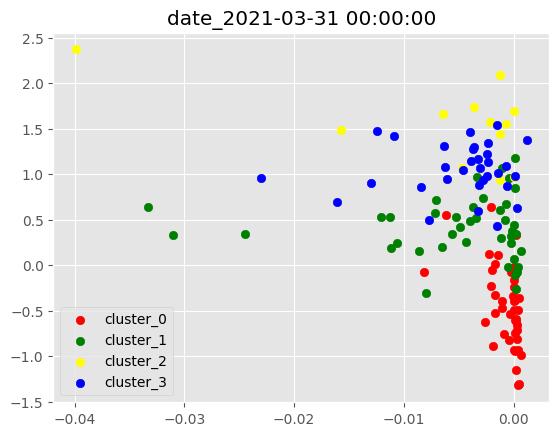

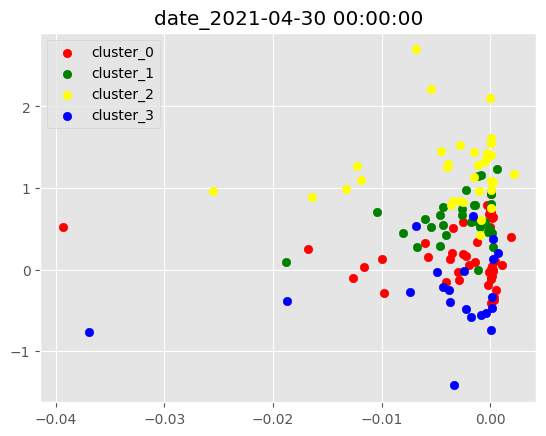

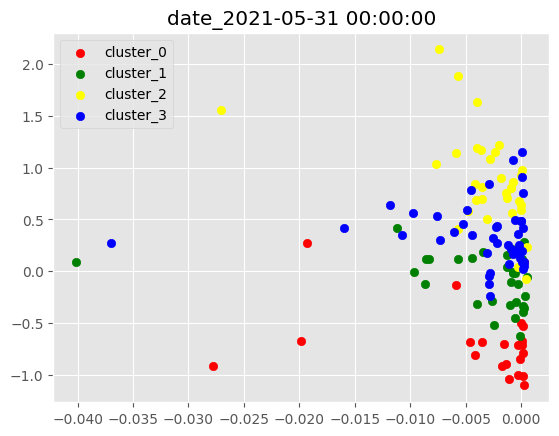

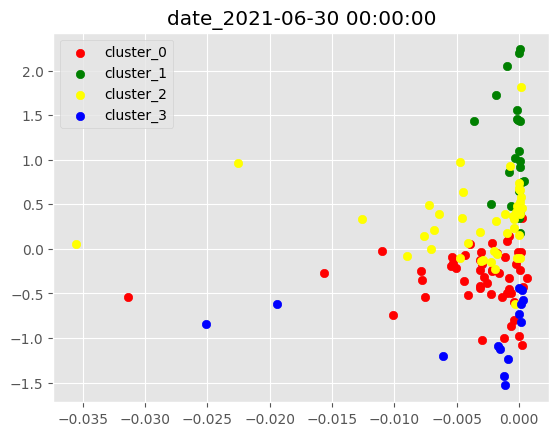

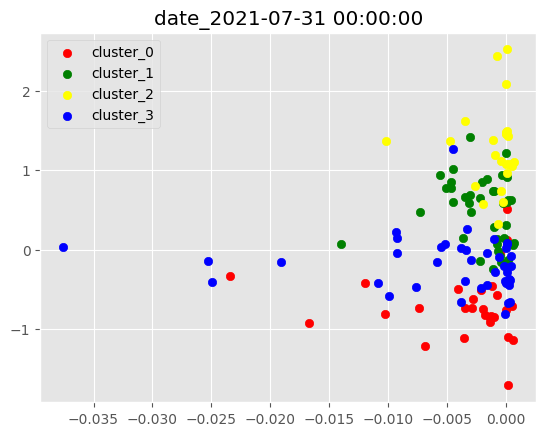

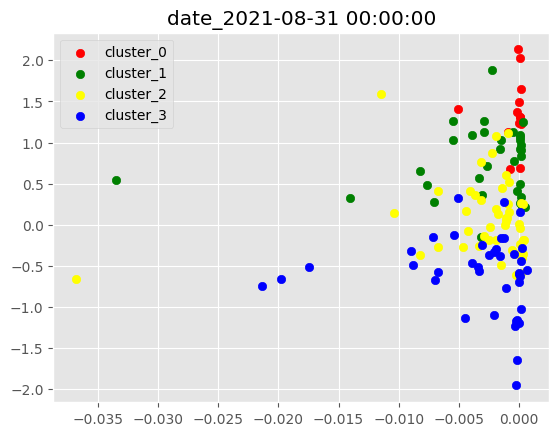

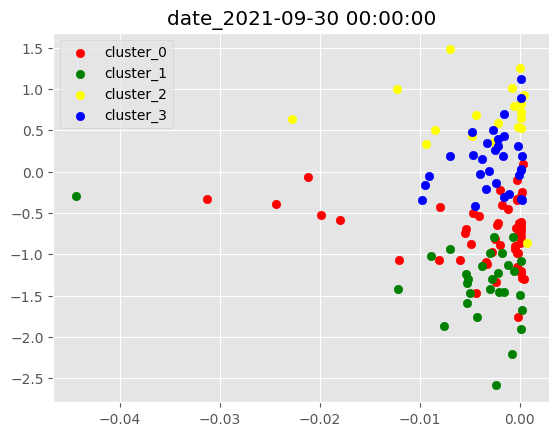

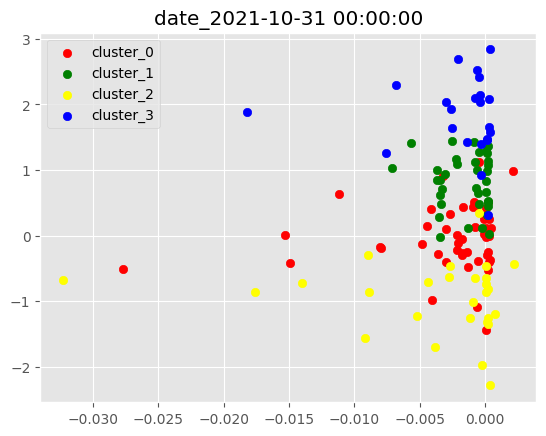

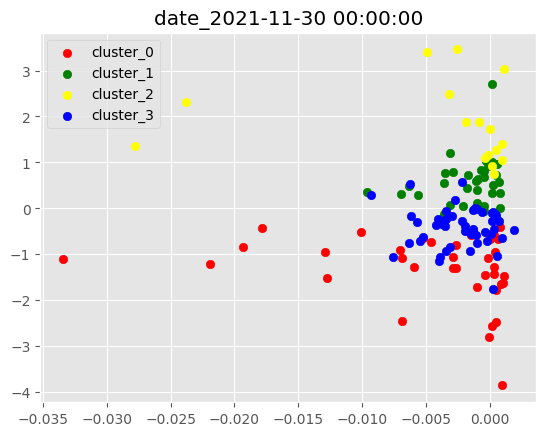

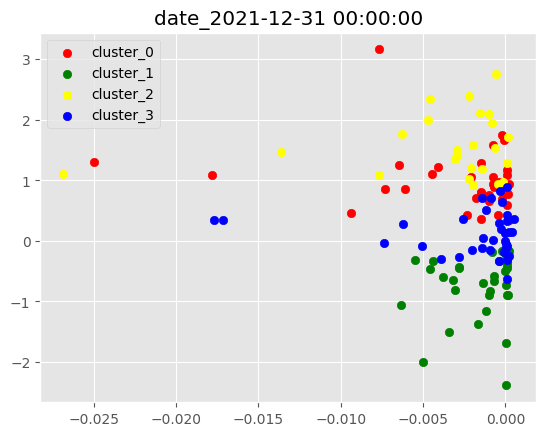

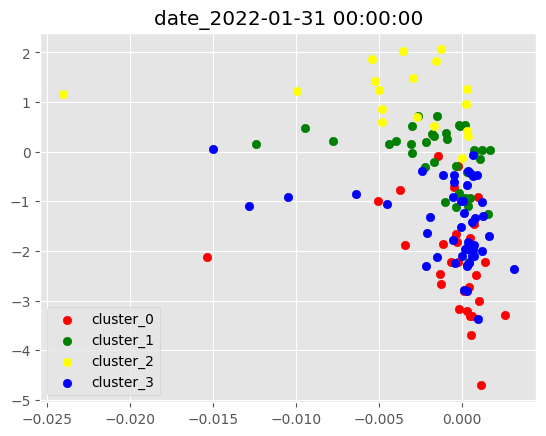

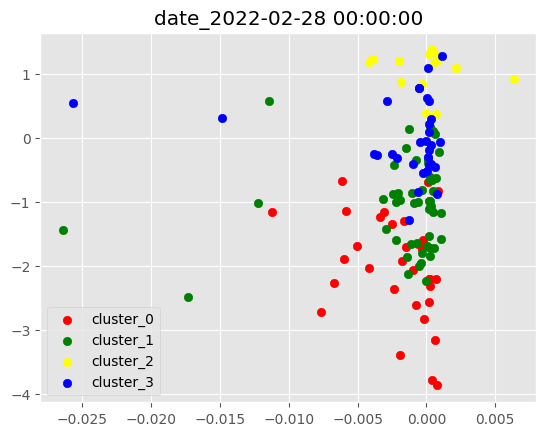

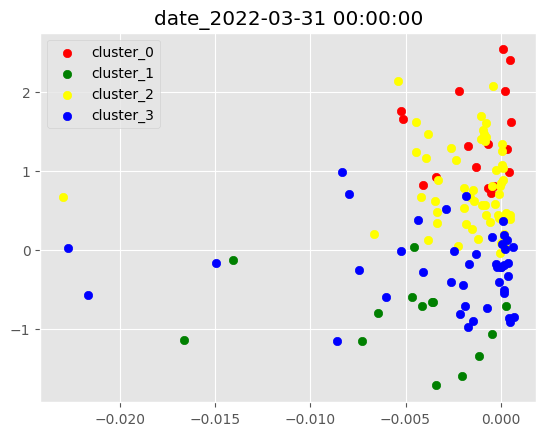

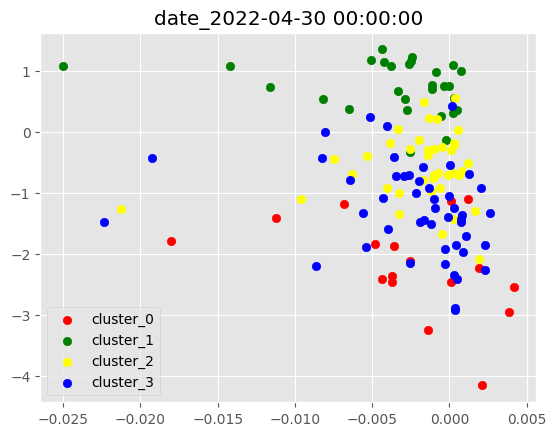

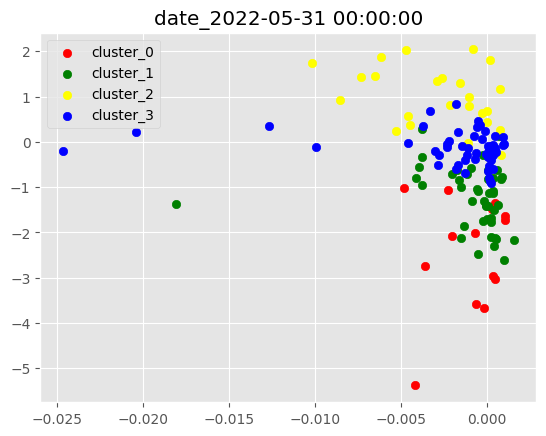

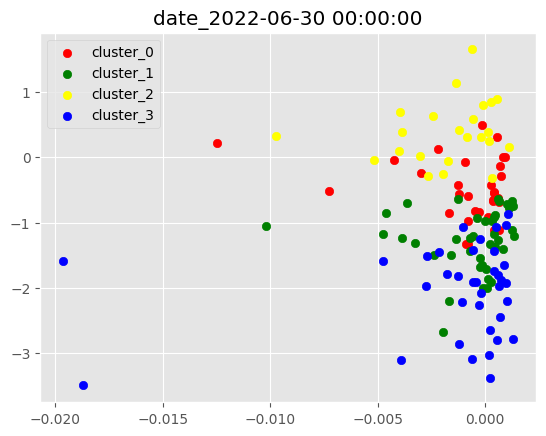

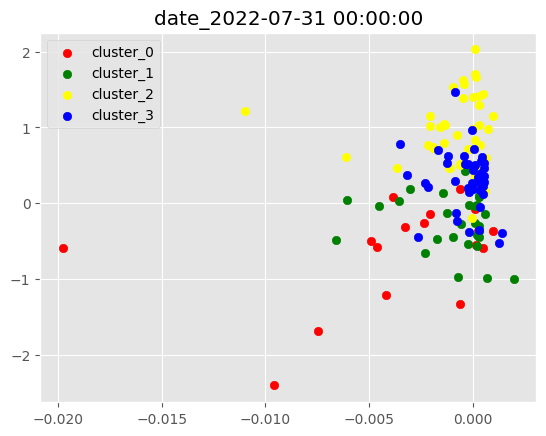

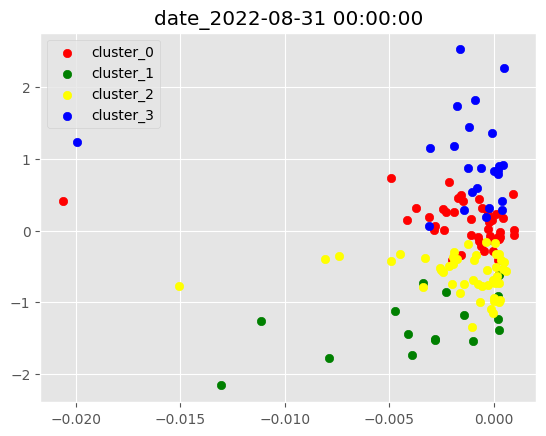

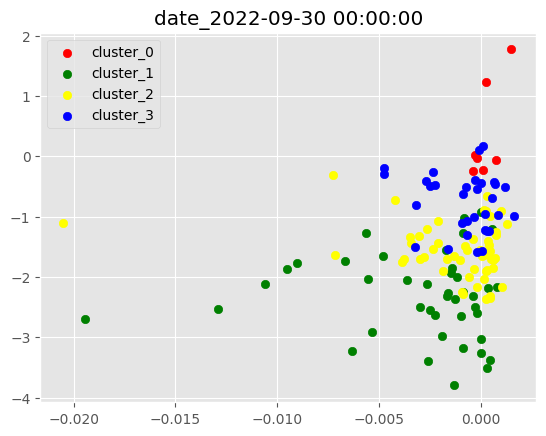

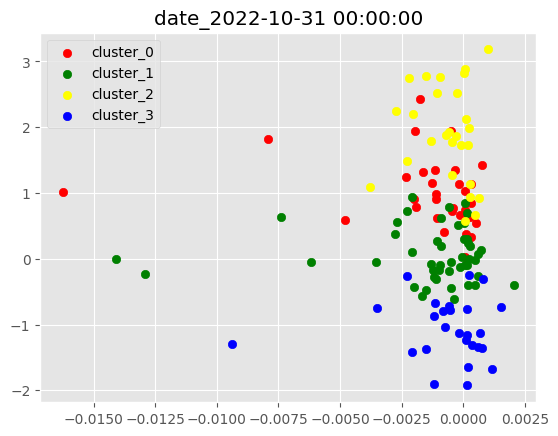

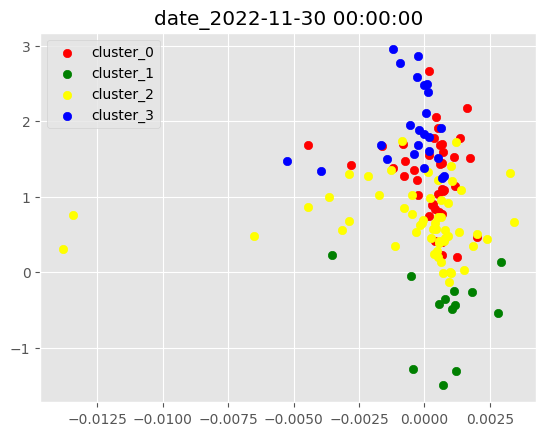

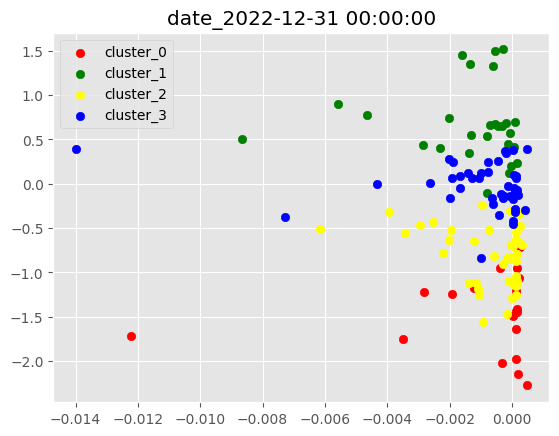

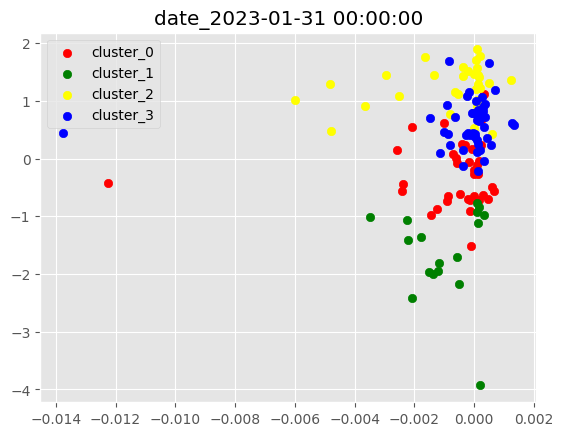

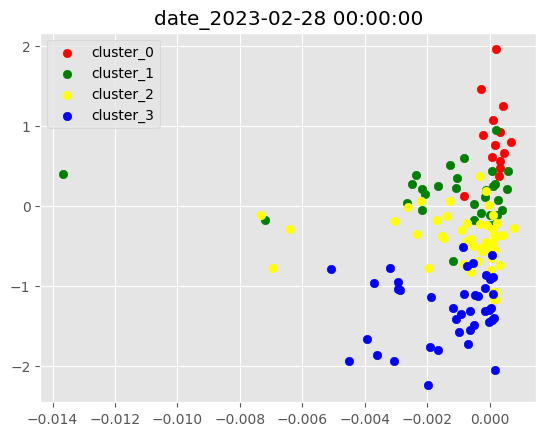

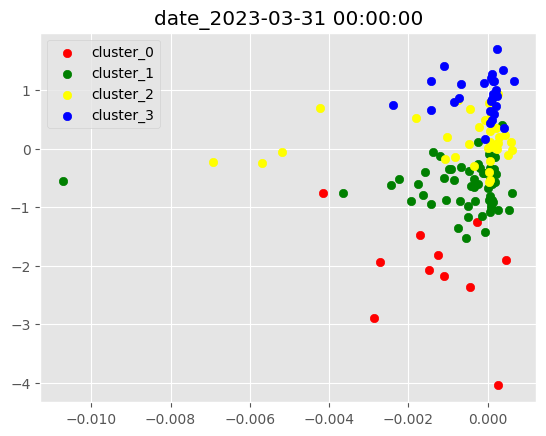

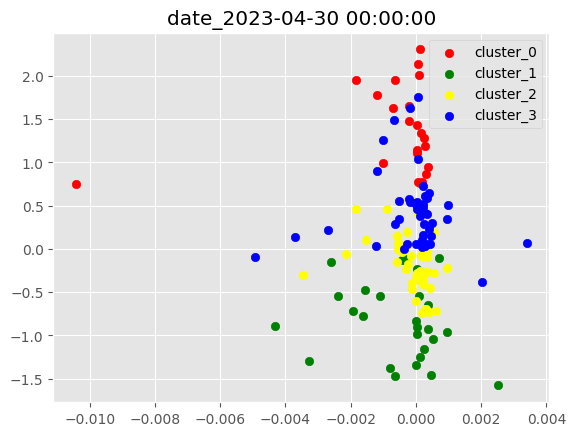

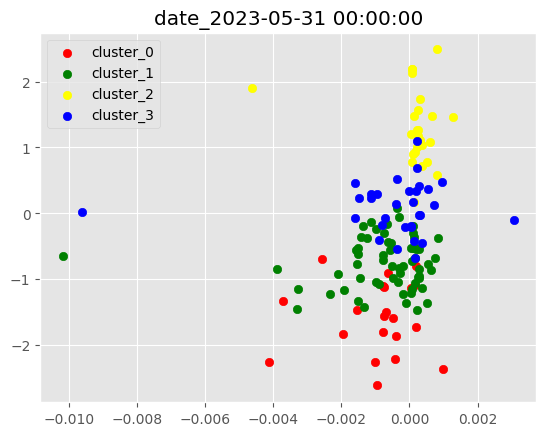

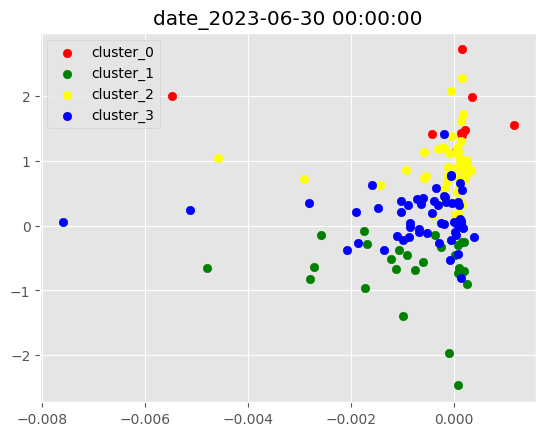

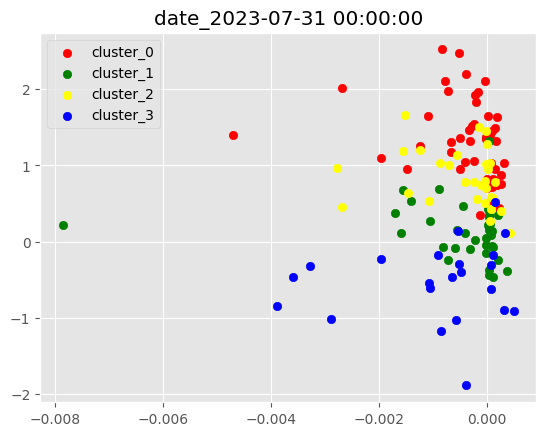

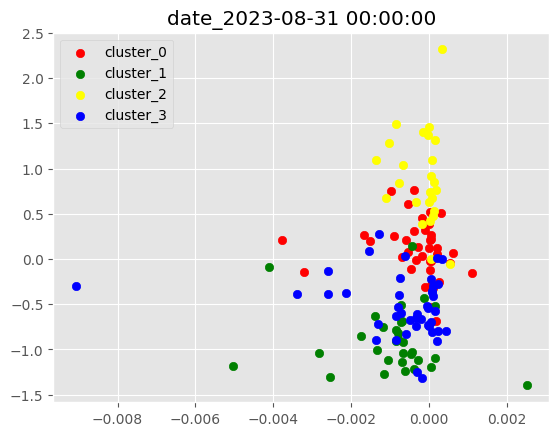

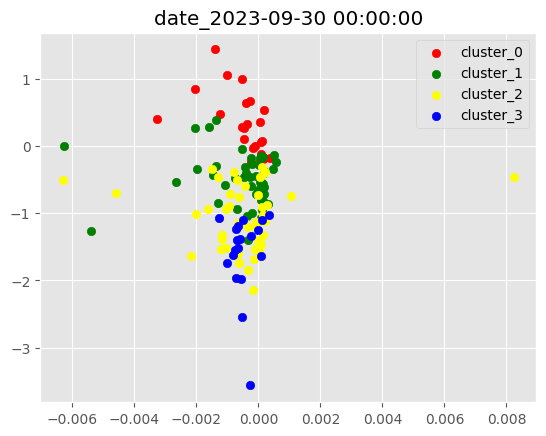

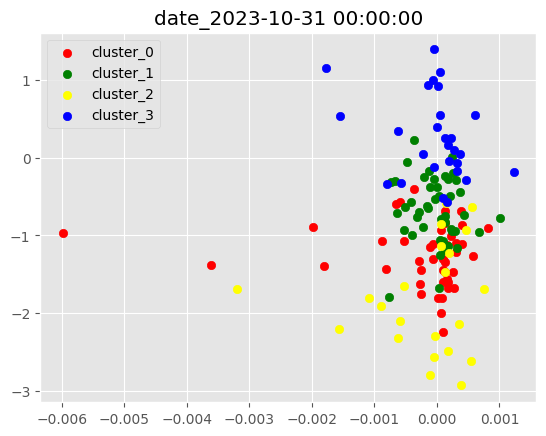

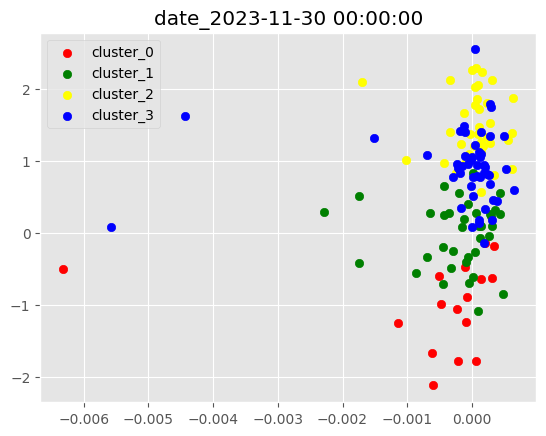

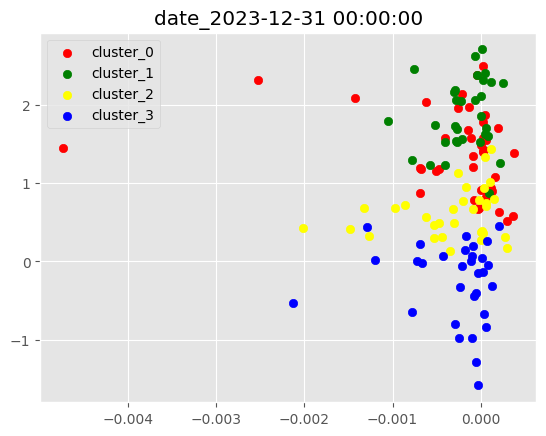

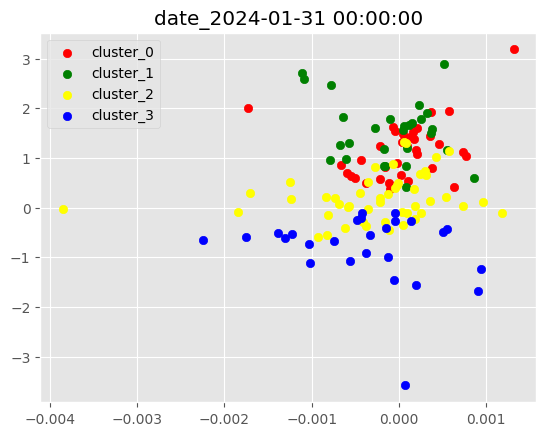

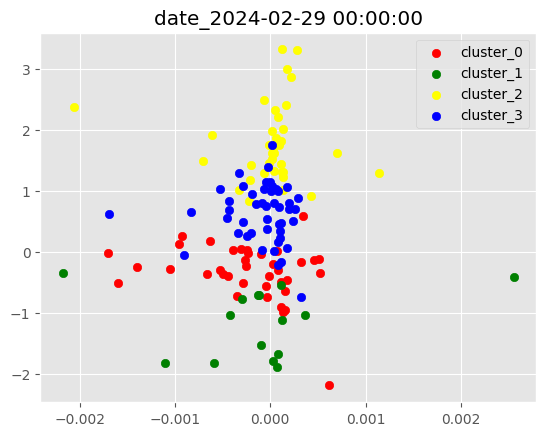

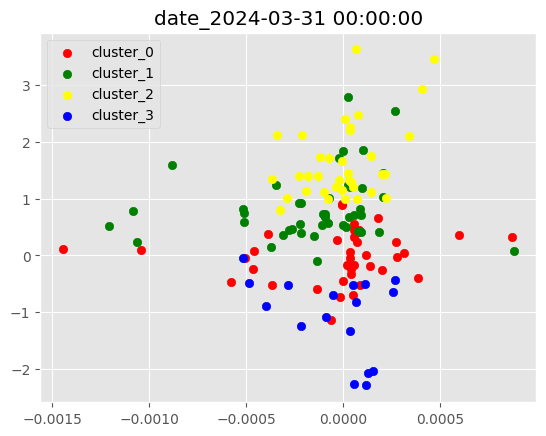

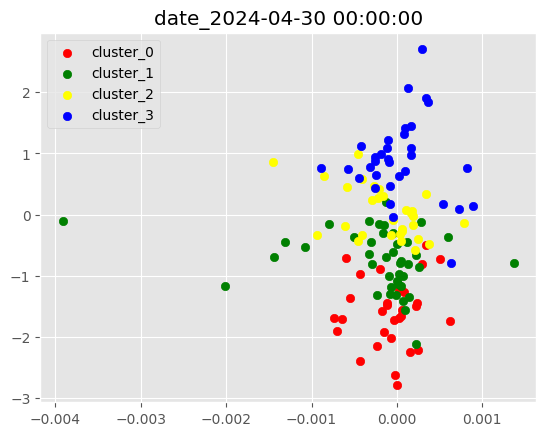

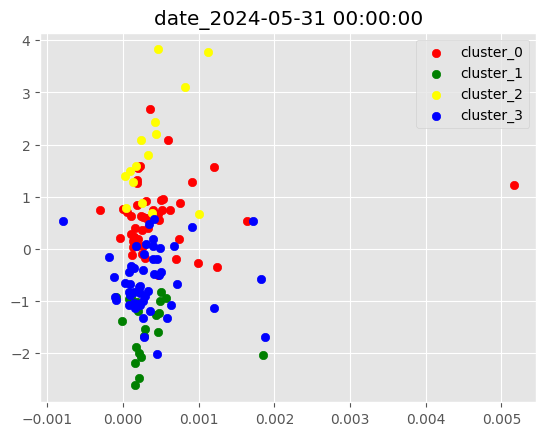

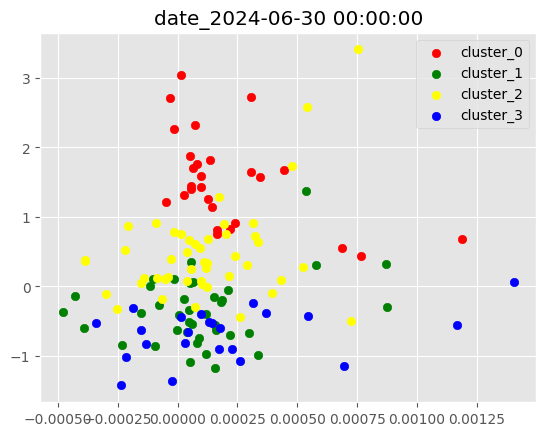

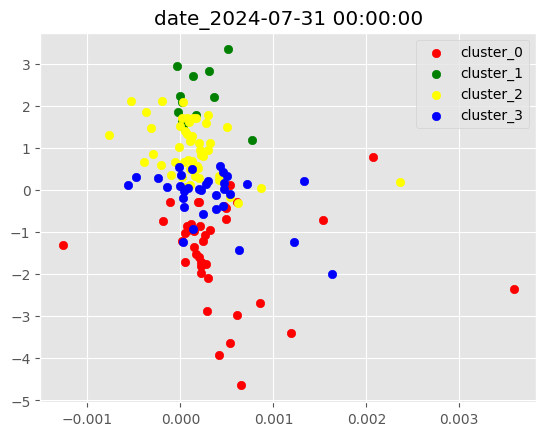

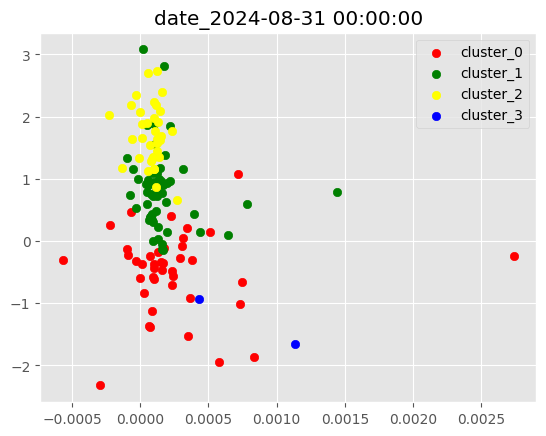

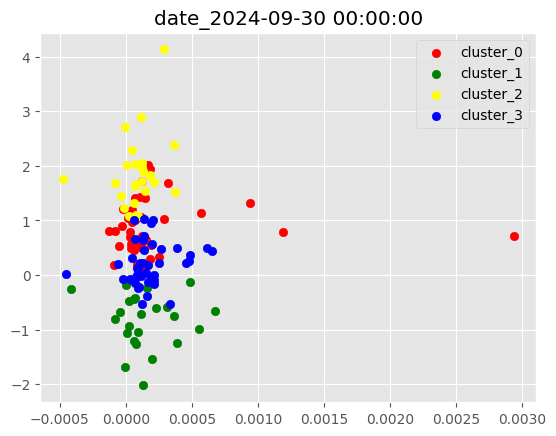

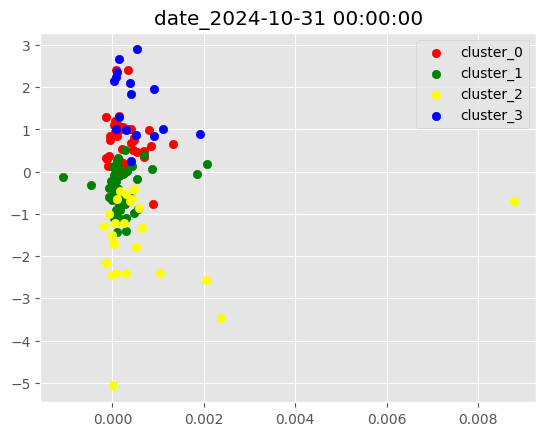

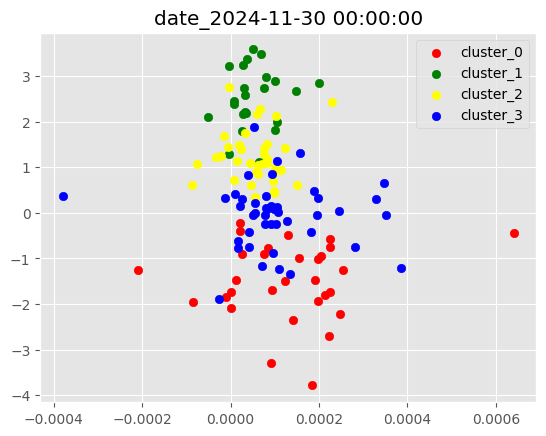

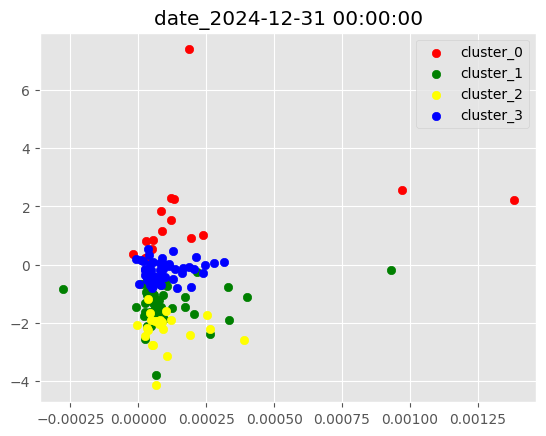

In [21]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level = 0)
    plt.title(f'date_{i}')
    plot_clusters(g)
